Phase 1 - Data Pre-Processing

In [2]:
# important libraries to import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import silhouette_score, normalized_mutual_info_score


In [3]:
df = pd.read_csv('Crime_Data_from_2020_to_Present.csv')
print("Initial shape of data:", df.shape)

Initial shape of data: (955339, 28)


In [4]:
# Cleaning location column and removing duplicates
if 'LOCATION' in df.columns:
    df['LOCATION'] = df['LOCATION'].astype(str).str.replace(r'\s+', ' ', regex=True).str.strip()
    df.drop_duplicates(subset='LOCATION', keep='first', inplace=True)


# 1. HANDLE MISSING VALUES
print("\nMissing values before cleaning:")
print(df.isnull().sum())

if 'Victim Age' in df.columns:
    df['Victim Age'] = df['Victim Age'].fillna(df['Victim Age'].median())
    df = df[df['Victim Age'] >= 0]  # Remove invalid negative ages

categorical_columns = ['Vict Descent', 'Weapon Used Cd', 'Premis Desc', 'Crm Cd Desc', 'AREA NAME']
for col in categorical_columns:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')



Missing values before cleaning:
DR_NO                 0
Date Rptd             0
DATE OCC              0
TIME OCC              0
AREA                  0
AREA NAME             0
Rpt Dist No           0
Part 1-2              0
Crm Cd                0
Crm Cd Desc           0
Mocodes           11350
Vict Age              0
Vict Sex          10684
Vict Descent      10684
Premis Cd             1
Premis Desc          26
Weapon Used Cd    48258
Weapon Desc       48258
Status                0
Status Desc           0
Crm Cd 1              0
Crm Cd 2          61140
Crm Cd 3          65618
Crm Cd 4          65765
LOCATION              0
Cross Street      56622
LAT                   0
LON                   0
dtype: int64


In [5]:
print("\nMissing values after cleaning:")
print(df.isnull().sum())


Missing values after cleaning:
DR_NO                 0
Date Rptd             0
DATE OCC              0
TIME OCC              0
AREA                  0
AREA NAME             0
Rpt Dist No           0
Part 1-2              0
Crm Cd                0
Crm Cd Desc           0
Mocodes           11350
Vict Age              0
Vict Sex          10684
Vict Descent          0
Premis Cd             1
Premis Desc           0
Weapon Used Cd        0
Weapon Desc       48258
Status                0
Status Desc           0
Crm Cd 1              0
Crm Cd 2          61140
Crm Cd 3          65618
Crm Cd 4          65765
LOCATION              0
Cross Street      56622
LAT                   0
LON                   0
dtype: int64


In [6]:
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], format='%Y-%m-%d', errors='coerce')

# Check if 'DATE RPTD' exists before processing
if 'DATE RPTD' in df.columns:
    df['DATE RPTD'] = pd.to_datetime(df['DATE RPTD'], format='%Y-%m-%d', errors='coerce')
else:
    print("Column 'DATE RPTD' does not exist in the DataFrame.")

# 2. ENCODE CATEGORICAL VARIABLES
label_encoders = {}
for col in categorical_columns:
    LE = LabelEncoder()
    df[col] = df[col].astype(str)
    df[col] = LE.fit_transform(df[col])
    label_encoders[col] = LE

print("\nSample label encoding for 'Crm Cd Desc':")
if 'Crm Cd Desc' in label_encoders:
    LE = label_encoders['Crm Cd Desc']
    print(dict(zip(LE.classes_, LE.transform(LE.classes_))))

Column 'DATE RPTD' does not exist in the DataFrame.

Sample label encoding for 'Crm Cd Desc':
{'ARSON': np.int64(0), 'ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER': np.int64(1), 'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT': np.int64(2), 'ATTEMPTED ROBBERY': np.int64(3), 'BATTERY - SIMPLE ASSAULT': np.int64(4), 'BATTERY ON A FIREFIGHTER': np.int64(5), 'BATTERY POLICE (SIMPLE)': np.int64(6), 'BATTERY WITH SEXUAL CONTACT': np.int64(7), 'BIGAMY': np.int64(8), 'BIKE - ATTEMPTED STOLEN': np.int64(9), 'BIKE - STOLEN': np.int64(10), 'BOAT - STOLEN': np.int64(11), 'BOMB SCARE': np.int64(12), 'BRANDISH WEAPON': np.int64(13), 'BUNCO, ATTEMPT': np.int64(14), 'BUNCO, GRAND THEFT': np.int64(15), 'BUNCO, PETTY THEFT': np.int64(16), 'BURGLARY': np.int64(17), 'BURGLARY FROM VEHICLE': np.int64(18), 'BURGLARY FROM VEHICLE, ATTEMPTED': np.int64(19), 'BURGLARY, ATTEMPTED': np.int64(20), 'CHILD ABANDONMENT': np.int64(21), 'CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT': np.int64(22), 'CHILD ABUSE (PHYSICA

In [7]:
# 3. DATE CLEANING AND CONVERSION
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], errors='coerce')

# to check if 'TIME OCC' exists before processing
if 'TIME OCC' in df.columns:
	df['TIME OCC'] = df['TIME OCC'].apply(lambda x: f"{int(x):04}")
	df['Hour'] = df['TIME OCC'].str[:2].astype(int)
else:
	print("Column 'TIME OCC' does not exist in the DataFrame.")

In [8]:
# 4. FEATURE ENGINEERING
if 'TIME OCC' in df.columns:
    df['Hour'] = df['TIME OCC'].apply(lambda x: int(str(x).zfill(4)[:2]))
else:
    print("Column 'TIME OCC' does not exist in the DataFrame. Skipping 'Hour' feature engineering.")

df['DayOfWeek'] = df['DATE OCC'].dt.day_name()
df['Month'] = df['DATE OCC'].dt.month
df['Year'] = df['DATE OCC'].dt.year

def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

if 'Hour' in df.columns:
    df['TimeOfDay'] = df['Hour'].apply(time_of_day)
    df['TimeOfDay'] = LabelEncoder().fit_transform(df['TimeOfDay'])
    print("\nTimeOfDay distribution:")
    print(df['TimeOfDay'].value_counts())
else:
    print("Column 'Hour' does not exist in the DataFrame. Skipping 'TimeOfDay' feature engineering.")


TimeOfDay distribution:
TimeOfDay
3    18204
0    17823
1    15148
2    14594
Name: count, dtype: int64


In [9]:
# 5. ENCODE CATEGORICAL VARIABLES
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

print("\nSample label encoding for 'Crm Cd Desc':")
if 'Crm Cd Desc' in label_encoders:
    le = label_encoders['Crm Cd Desc']
    print(dict(zip(le.classes_, le.transform(le.classes_))))


Sample label encoding for 'Crm Cd Desc':
{np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3), np.int64(4): np.int64(4), np.int64(5): np.int64(5), np.int64(6): np.int64(6), np.int64(7): np.int64(7), np.int64(8): np.int64(8), np.int64(9): np.int64(9), np.int64(10): np.int64(10), np.int64(11): np.int64(11), np.int64(12): np.int64(12), np.int64(13): np.int64(13), np.int64(14): np.int64(14), np.int64(15): np.int64(15), np.int64(16): np.int64(16), np.int64(17): np.int64(17), np.int64(18): np.int64(18), np.int64(19): np.int64(19), np.int64(20): np.int64(20), np.int64(21): np.int64(21), np.int64(22): np.int64(22), np.int64(23): np.int64(23), np.int64(24): np.int64(24), np.int64(25): np.int64(25), np.int64(26): np.int64(26), np.int64(27): np.int64(27), np.int64(28): np.int64(28), np.int64(29): np.int64(29), np.int64(30): np.int64(30), np.int64(31): np.int64(31), np.int64(32): np.int64(32), np.int64(33): np.int64(33), np.int64(34): np.int64(34

In [10]:
# 6. DROP IRRELEVANT COLUMNS
columns_to_drop = ['DR_NO', 'Rpt Dist No', 'LAT', 'LON', 'TIME OCC', 'LOCATION']
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

print("\nFinal shape of data after preprocessing:", df.shape)


Final shape of data after preprocessing: (65769, 27)


Phase 2 - EDA AND PCA

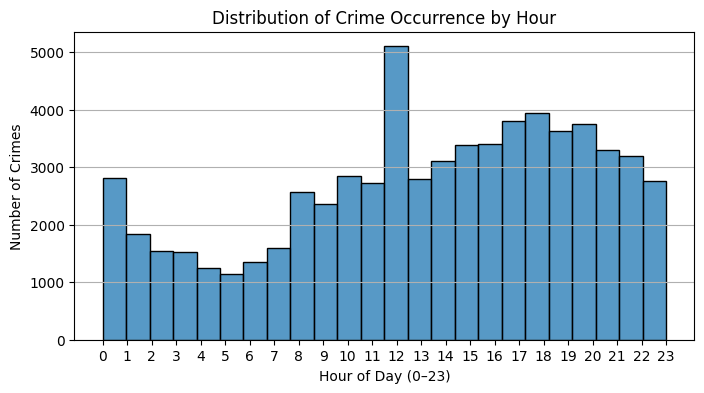

In [11]:
plt.figure(figsize=(8, 4)) # Visualize when crimes are most commonly reported throughout the day.
sns.histplot(df['Hour'], bins=24, kde=False)
plt.title("Distribution of Crime Occurrence by Hour")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Crimes")
plt.xticks(range(0, 24))
plt.grid(axis='y')
plt.show()

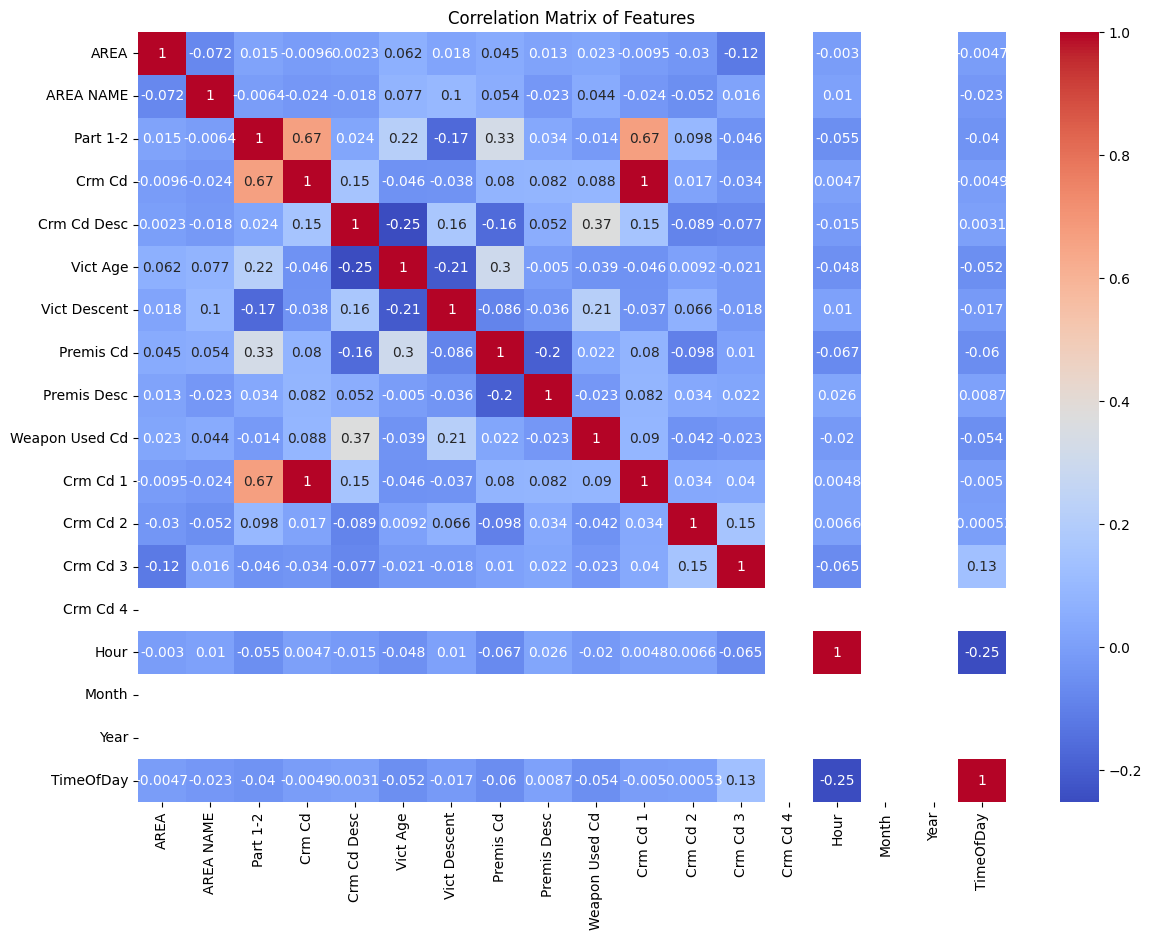

In [12]:
plt.figure(figsize=(14, 10))
numeric_cols = df.select_dtypes(include=[np.number]).columns
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Features")
plt.show()


In [13]:
print(df[numeric_cols].isnull().sum())

AREA                  0
AREA NAME             0
Part 1-2              0
Crm Cd                0
Crm Cd Desc           0
Vict Age              0
Vict Descent          0
Premis Cd             1
Premis Desc           0
Weapon Used Cd        0
Crm Cd 1              0
Crm Cd 2          61140
Crm Cd 3          65618
Crm Cd 4          65765
Hour                  0
Month             65769
Year              65769
TimeOfDay             0
dtype: int64


In [14]:
cols_to_drop_for_pca = ['Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'Month', 'Year'] # Since PCA requires numeric data, we need to drop non-numeric columns
df_pca_ready = df.drop(columns=cols_to_drop_for_pca, errors='ignore')

# Select only numeric columns again
numeric_cols = df_pca_ready.select_dtypes(include=[np.number]).columns

In [15]:
# Handle missing values by filling them with the mean of each column
df_filled = df[numeric_cols].fillna(df[numeric_cols].mean())

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_filled)
pca = PCA()  # Use the existing PCA object from sklearn.decomposition
pca_data = pca.fit_transform(df_scaled)

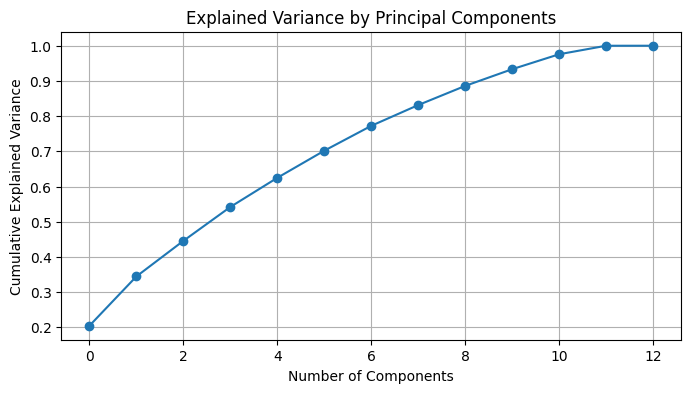

In [16]:
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

Phase 3 - K-Means Clustering

In [16]:
# compare the models based on the same sample of data
sample_size = 25000
sample_indices = np.random.choice(len(pca_data), size=sample_size, replace=False)
pca_sample = pca_data[sample_indices]

In [17]:
k = 5

In [21]:
# k-means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_sample)
kmeans_score = silhouette_score(pca_sample, kmeans_labels)
print(f"KMeans Silhouette Score: {kmeans_score:.4f}")

KMeans Silhouette Score: 0.1389


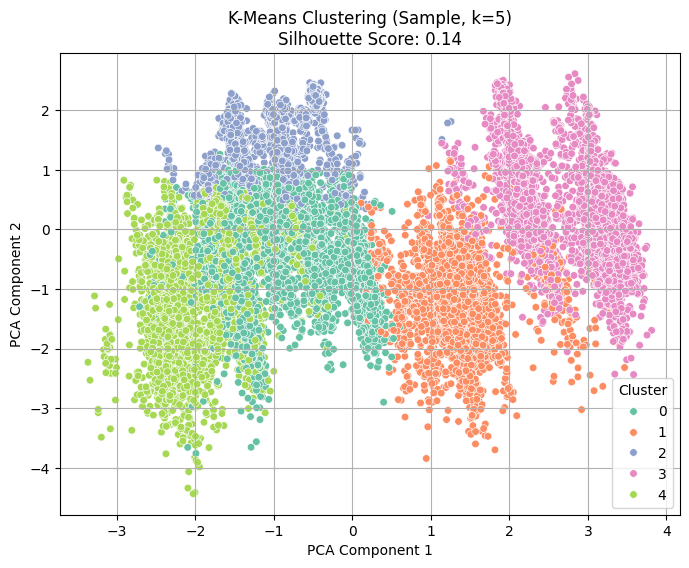

In [22]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_sample[:, 0], y=pca_sample[:, 1], hue=kmeans_labels, palette='Set2', s=30)
plt.title(f"K-Means Clustering (Sample, k={k})\nSilhouette Score: {kmeans_score:.2f}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.legend(title="Cluster")
plt.show()

In [ ]:
# Agglomerative clustering
agglo = AgglomerativeClustering(n_clusters=k)
agglo_labels = agglo.fit_predict(pca_sample)
agglo_score = silhouette_score(pca_sample, agglo_labels)
print(f"Agglomerative Clustering Silhouette Score: {agglo_score:.4f}")

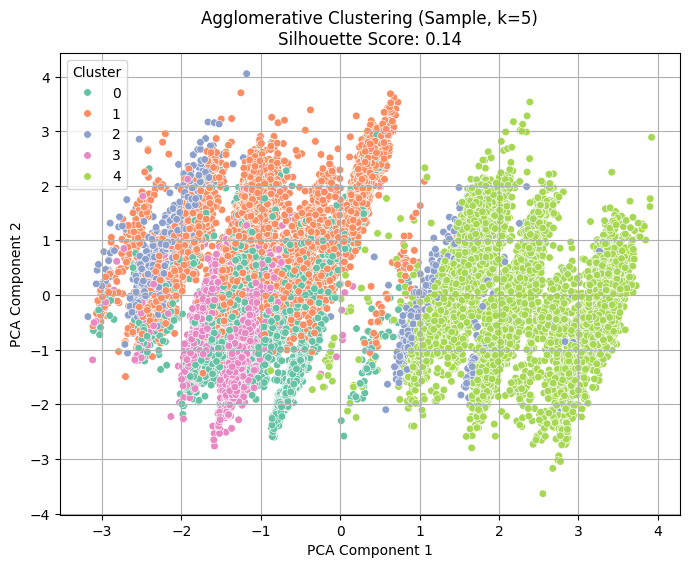

In [27]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_sample[:, 0], y=pca_sample[:, 1], hue=agglo_labels, palette='Set2', s=30)
plt.title(f"Agglomerative Clustering (Sample, k={k})\nSilhouette Score: {agglo_score:.2f}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.legend(title="Cluster")
plt.show()

In [22]:
# Spectral clustering
spectral = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
spectral_labels = spectral.fit_predict(pca_sample)
spectral_score = silhouette_score(pca_sample, spectral_labels)
print(f"Spectral Clustering Silhouette Score: {spectral_score:.4f}")

c:\Users\allan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Spectral Clustering Silhouette Score: -0.1625


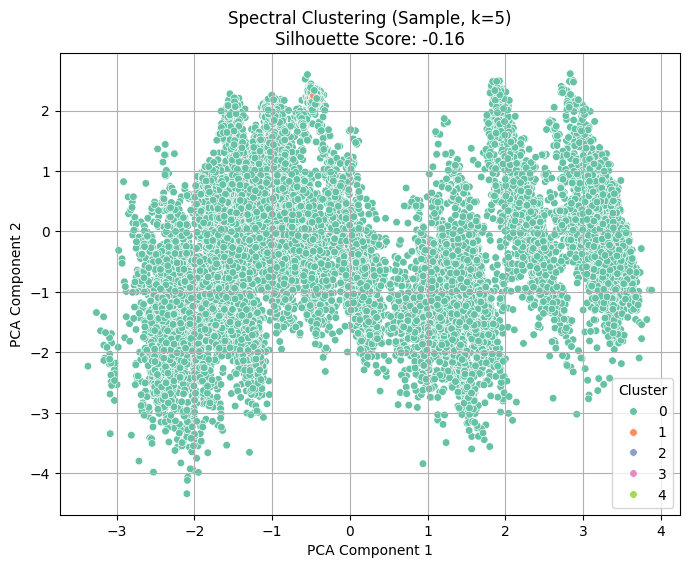

In [140]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_sample[:, 0], y=pca_sample[:, 1], hue=spectral_labels, palette='Set2', s=30)
plt.title(f"Spectral Clustering (Sample, k={k})\nSilhouette Score: {spectral_score:.2f}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.legend(title="Cluster")
plt.show()

In [141]:
print("\n Silhouette Score Comparison (Sample):")
print(f"• K-Means        : {kmeans_score:.4f}")
print(f"• Agglomerative  : {agglo_score:.4f}")
print(f"• Spectral       : {spectral_score:.4f}")


 Silhouette Score Comparison (Sample):
• K-Means        : 0.1544
• Agglomerative  : 0.1397
• Spectral       : -0.1589


In [18]:
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_data)
score_kmeans = silhouette_score(pca_data, kmeans_labels)
print(f"K-Means Silhouette Score (k={k}): {score_kmeans:.4f}")

K-Means Silhouette Score (k=5): 0.1394


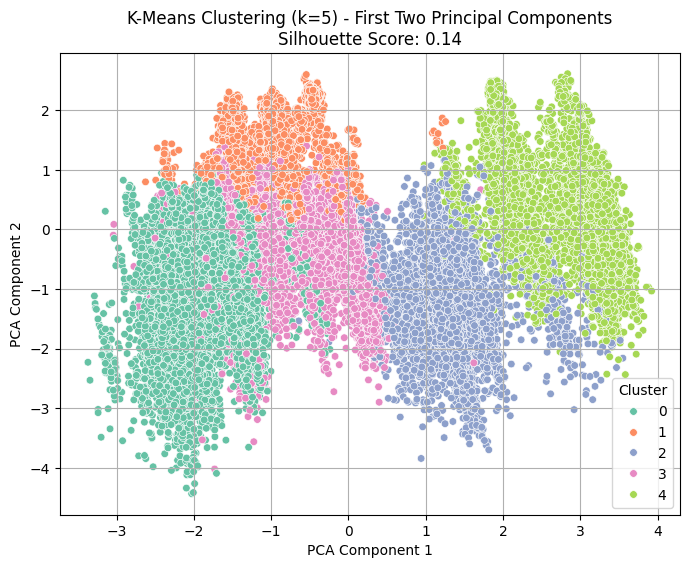

In [19]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=kmeans_labels, palette='Set2', s=30)
plt.title(f"K-Means Clustering (k={k}) - First Two Principal Components\nSilhouette Score: {score_kmeans:.2f}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [20]:
# Final K-Means model on full dataset
final_kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = final_kmeans.fit_predict(pca_data)


In [21]:
if 'Crm Cd' in df.columns:
    nmi = normalized_mutual_info_score(df['Crm Cd'], df['Cluster'])
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
else:
    print("NMI skipped: no categorical column like 'Crm Cd' found.")

Normalized Mutual Information (NMI): 0.5396


Phase 4 - Evaluation and Results

In [22]:
# See number of crimes per cluster
print(df['Cluster'].value_counts())


Cluster
0    15942
1    15841
3    12330
4    11500
2    10156
Name: count, dtype: int64


Cluster
0    40.585999
1     9.869768
2    37.938952
3    43.184185
4    36.498696
Name: Vict Age, dtype: float64


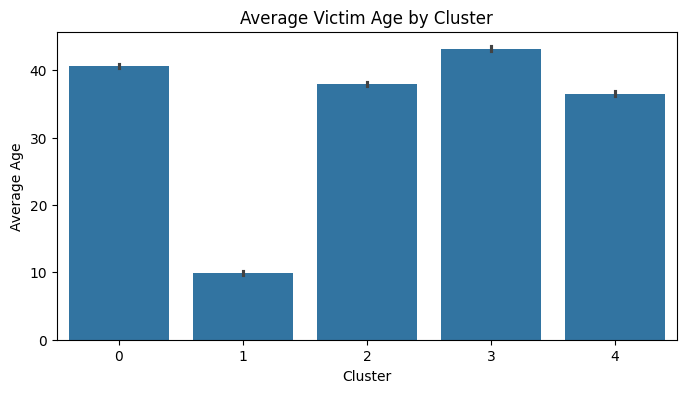

In [23]:
# Average victim age per cluster
print(df.groupby('Cluster')['Vict Age'].mean())

plt.figure(figsize=(8, 4))
sns.barplot(x='Cluster', y='Vict Age', data=df)
plt.title("Average Victim Age by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Age")
plt.show()


Cluster  Crm Cd Desc
0        17             4535
         18             4295
         2              2363
1        117            8637
         99             2924
         98             1435
2        4              3535
         62             2926
         13              691
3        101            5193
         103            2195
         108            1373
4        114            3823
         115            1834
         112            1109
Name: count, dtype: int64


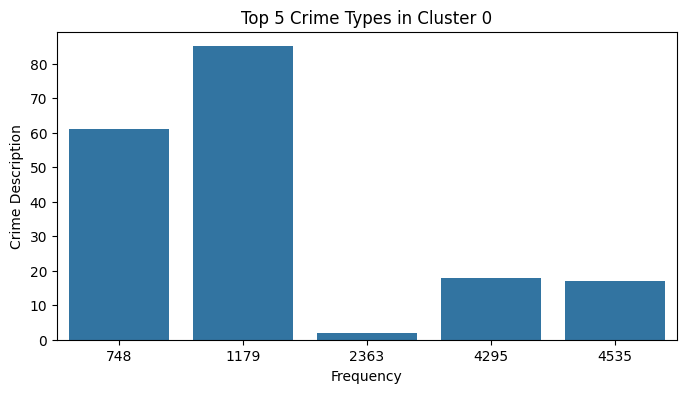

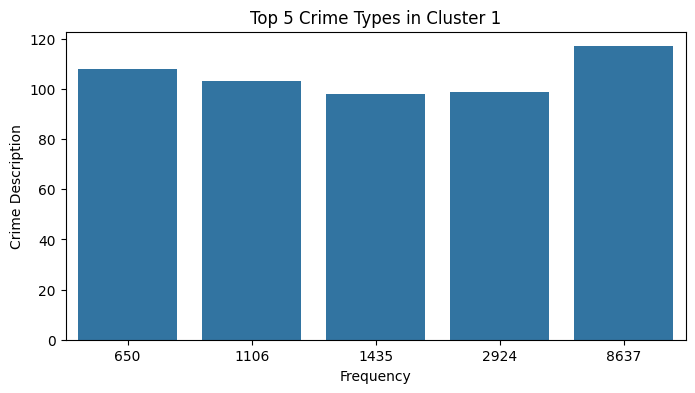

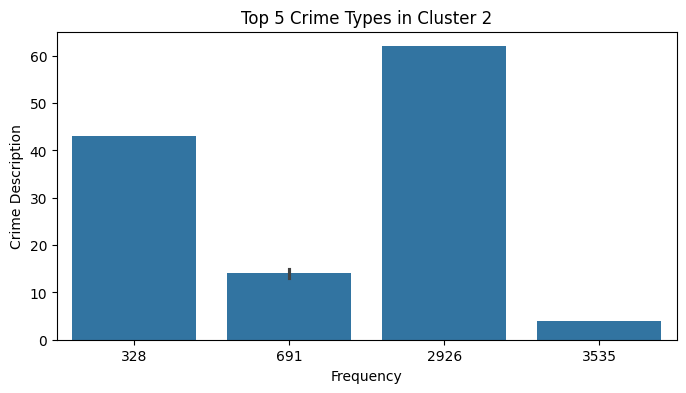

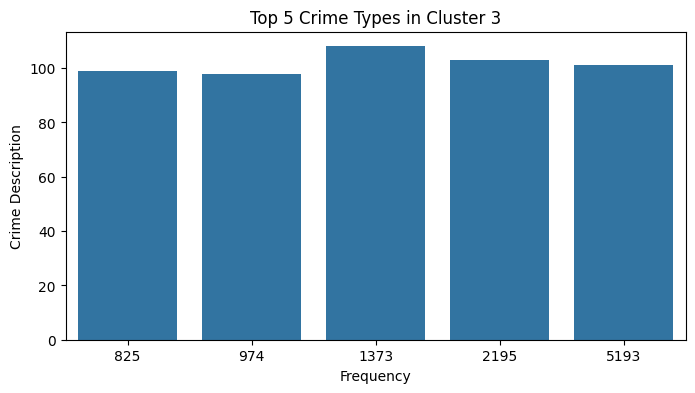

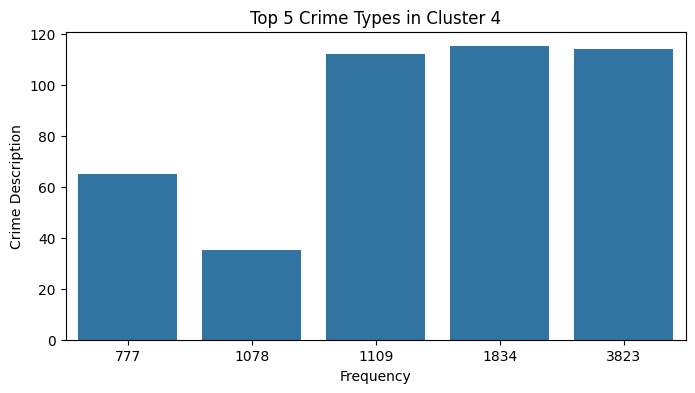

In [24]:
# Most frequent crime descriptions
print(df.groupby('Cluster')['Crm Cd Desc'].value_counts().groupby(level=0).head(3))

for c in sorted(df['Cluster'].unique()):
    plt.figure(figsize=(8, 4))
    top_crimes = df[df['Cluster'] == c]['Crm Cd Desc'].value_counts().head(5)
    sns.barplot(x=top_crimes.values, y=top_crimes.index)
    plt.title(f"Top 5 Crime Types in Cluster {c}")
    plt.xlabel("Frequency")
    plt.ylabel("Crime Description")
    plt.show()


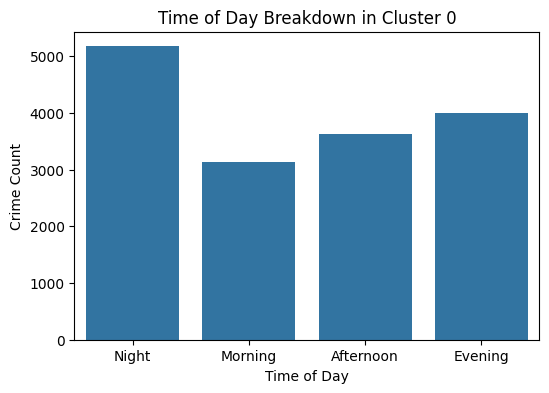

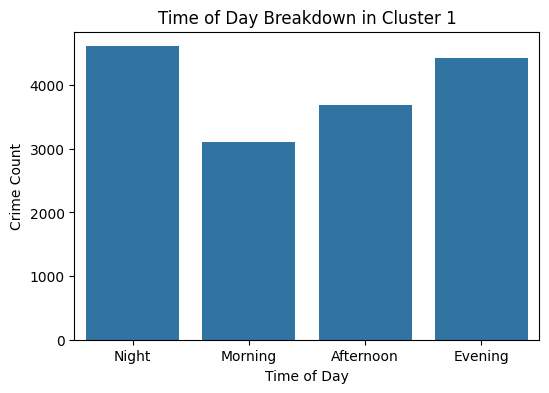

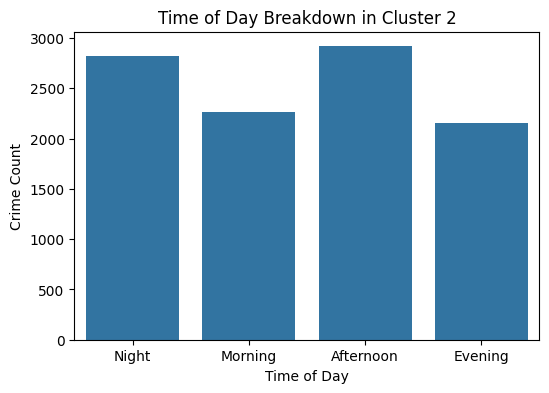

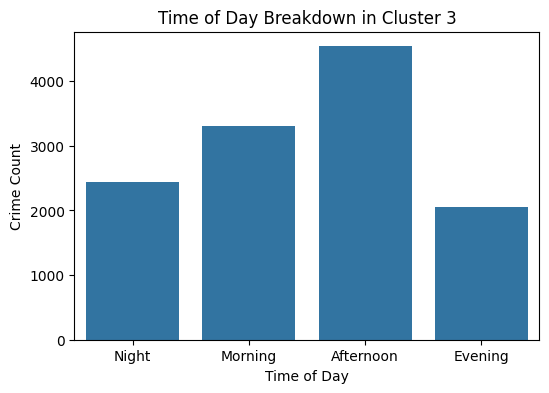

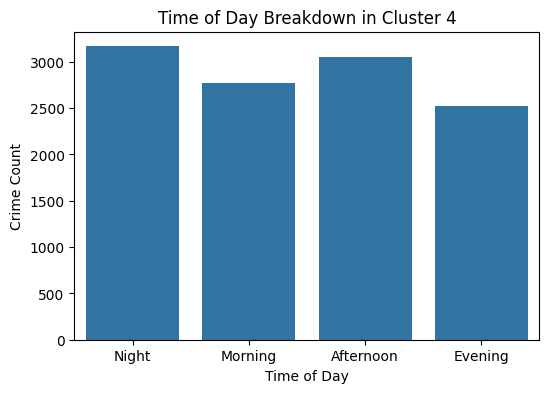

In [25]:
def time_of_day_label(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['TimeOfDayStr'] = df['Hour'].apply(time_of_day_label)


for c in sorted(df['Cluster'].unique()):
    plt.figure(figsize=(6, 4))
    time_counts = df[df['Cluster'] == c]['TimeOfDayStr'].value_counts().reindex(['Night', 'Morning', 'Afternoon', 'Evening'])
    sns.barplot(x=time_counts.index, y=time_counts.values)
    plt.title(f"Time of Day Breakdown in Cluster {c}")
    plt.xlabel("Time of Day")
    plt.ylabel("Crime Count")
    plt.show()





AREA NAME   0    1     2    3     4     5    6    7    8    9   ...   11  \
Cluster                                                         ...        
0          708  466  1201  734   766   705  565  605  831  607  ...  328   
1          698  248  1106  908  1219  1074  457  906  795  690  ...  319   
2          573  234   742  583   678   586  306  516  477  435  ...  247   
3          390  151  1281  568   554   363  432  514  686  246  ...  217   
4          543  266   790  622   752   601  433  543  625  378  ...  225   

AREA NAME    12   13   14   15   16   17    18    19   20  
Cluster                                                    
0          1251  402  680  685  899  651  1072  1056  672  
1          1081  471  609  630  671  614   725   774  480  
2           543  286  493  543  639  361   504   510  335  
3          1070  227  339  530  985  590  1090   791  519  
4           751  278  444  535  665  419   740   616  521  

[5 rows x 21 columns]


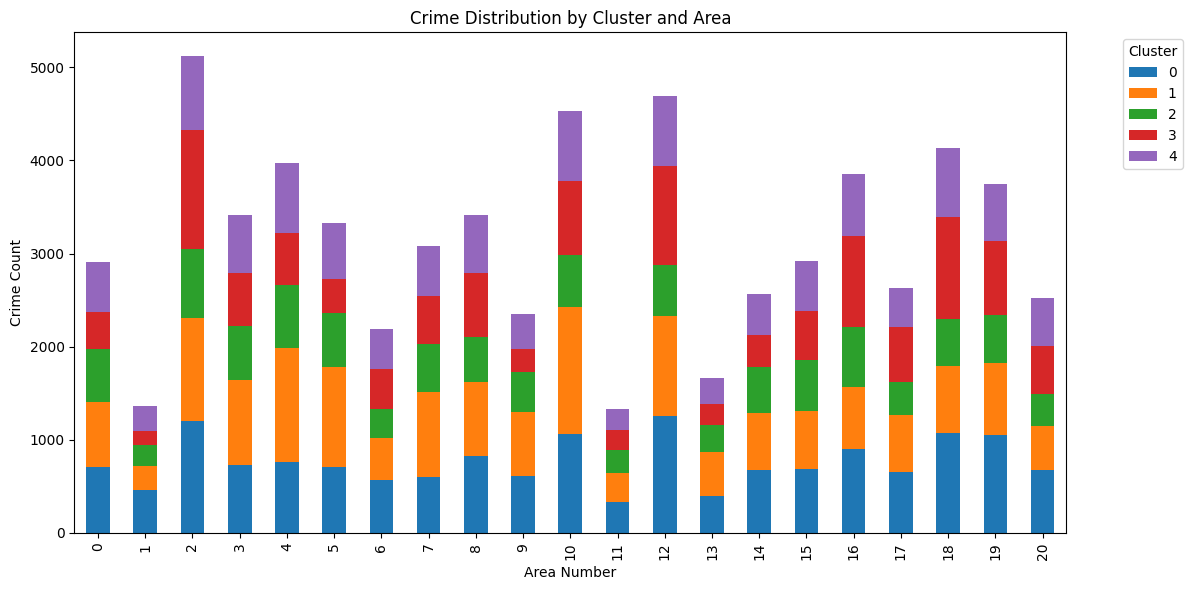

In [26]:
area_cluster_counts = df.groupby(['Cluster', 'AREA NAME']).size().unstack().fillna(0)

# View the top few rows
print(area_cluster_counts.head())

area_cluster_counts.T.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title("Crime Distribution by Cluster and Area")
plt.xlabel("Area Number")
plt.ylabel("Crime Count")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

